In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

import logging
logging.getLogger("jax").setLevel(logging.ERROR)

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

2024-05-29 14:02:45.515302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco")

In [3]:
from lib.network import get_network_eval_fn
from lib.plotting_tools import adjust_plot_1d

In [4]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [5]:
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [6]:
dist = 10
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
print(scipy.special.softmax(logits))
print(gamma_a)
print(gamma_b)

[0.29058582 0.58944076 0.11997342]
[1.36259072 3.60998841 1.00031693]
[0.04933167 0.80489579 0.00341855]


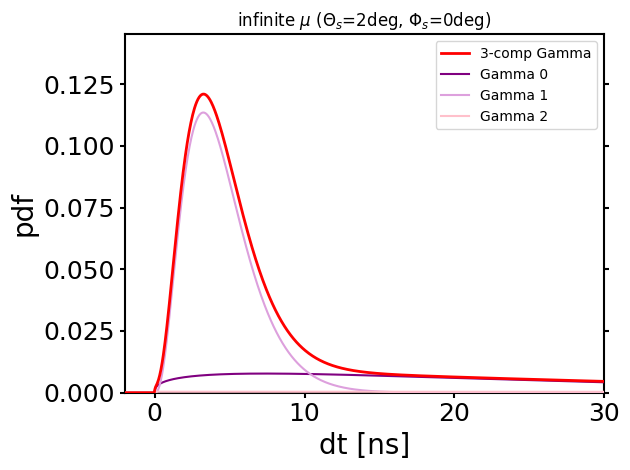

In [7]:
fig, ax = plt.subplots()

gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=gamma_a,       # One for each component.
            rate = gamma_b,
            force_probs_to_zero_outside_support=True
              )
    )

xvals = np.linspace(-10, 30, 1000)
yvals = gm.prob(xvals)
plt.plot(xvals, yvals, 'r-', zorder=10, linewidth=2, label='3-comp Gamma')

plot_args = {'xlim':[-2, 30],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'dt [ns]',
                 'ylabel':'pdf'}


w = jax.nn.softmax(logits)
for i,c in zip(range(3), ['purple', 'plum', 'pink']):
        tw = w[i]
        tg = tfd.Gamma(concentration=gamma_a[i], rate = gamma_b[i], force_probs_to_zero_outside_support=True)    
        yvals = tw * tg.prob(xvals)
        plt.plot(xvals, yvals, color=c,linestyle='solid', zorder=8, linewidth=1.5, label=f'Gamma {i}')

adjust_plot_1d(fig, ax, plot_args=plot_args)

ax.set_title(f"infinite $\mu$ ($\Theta_s$={zenith:.0f}deg, $\Phi_s$={azimuth:.0f}deg)")

plt.tight_layout()
plt.show()

In [8]:
def naive_gamma(x, a, b):
    return b**a / scipy.special.gamma(a) * x**(a-1) * np.exp(-b*x)

In [9]:
def cgamma_region1(x, a, b, sigma=3):
    '''
    exact eq. 7
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2
    
    fac1 = (b**a * sigma **(a-1) * np.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = scipy.special.hyp1f1(0.5*a, 0.5, s_eta_sq) / scipy.special.gamma(0.5*(a+1))
    s2 = scipy.special.hyp1f1(0.5*(a+1), 3./2., s_eta_sq) / scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

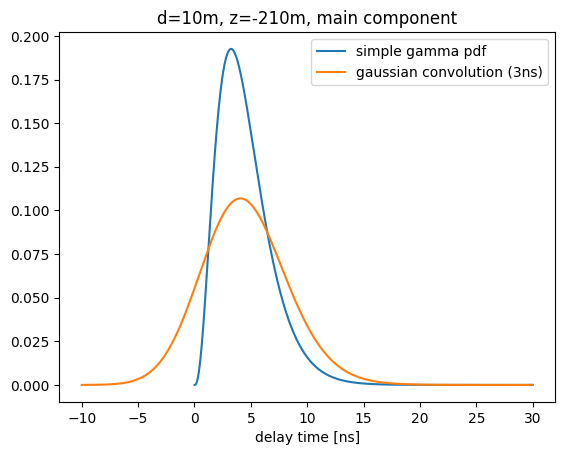

In [10]:
yvals = naive_gamma(xvals, gamma_a[1], gamma_b[1])
yvals_c = cgamma_region1(xvals, gamma_a[1], gamma_b[1])
fig, ax = plt.subplots()
ax.plot(xvals, yvals, label='simple gamma pdf')
ax.plot(xvals, yvals_c, label='gaussian convolution (3ns)')
plt.xlabel('delay time [ns]')
plt.title(f'd={dist:.0f}m, z={z:.0f}m, main component')
plt.legend()
plt.show()

In [11]:
# test integration
naive = lambda x: naive_gamma(x, gamma_a[1], gamma_b[1]) if x > 0 else 0.0
exact = lambda x: cgamma_region1(x, gamma_a[1], gamma_b[1])

In [12]:
scipy.integrate.quad(naive, -40, 40) # (0.9999999999719886, 1.6989690051539118e-09)

(0.9999999999719886, 1.6989690051539118e-09)

In [13]:
scipy.integrate.quad(exact, -20, 40) # (0.9999754706709623, 0.0001937529882428679) - explodes for t < -20

/tmp/ipykernel_46959/3496066602.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scipy.integrate.quad(exact, -20, 40) # (0.9999754706709623, 0.0001937529882428679) - explodes for t < -20


(0.9999754706709623, 0.0001937529882428679)

In [85]:
def naive_gamma_jax(x, a, b):
    return b**a / jax.scipy.special.gamma(a) * x**(a-1) * jnp.exp(-b*x)

@jax.jit
def cgamma_region1_jax(x, a, b, sigma=3):
    '''
    exact eq. 7
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2
    
    fac1 = (b**a * sigma **(a-1) * jnp.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = jax.scipy.special.hyp1f1(0.5*a, 0.5, s_eta_sq) / jax.scipy.special.gamma(0.5*(a+1))
    s2 = jax.scipy.special.hyp1f1(0.5*(a+1), 3./2., s_eta_sq) / jax.scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

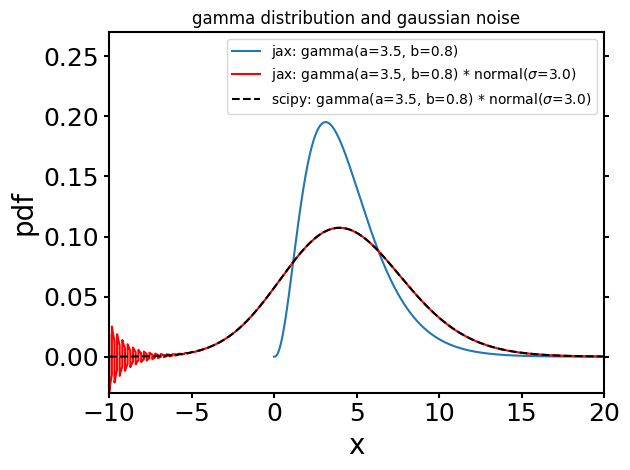

In [86]:
ga = 3.5
gb = 0.8
sigma=3

xvals = jnp.linspace(-10, 20, 10000)
yvals_n = naive_gamma_jax(xvals, ga, gb)
yvals_c = cgamma_region1_jax(xvals, ga, gb, sigma=sigma)

xvals = np.linspace(-10, 20, 10000)
yvals_csp = cgamma_region1(xvals, ga, gb, sigma=sigma)

fig, ax = plt.subplots()
plt.title("gamma distribution and gaussian noise")

ax.plot(xvals, yvals_n, label=f'jax: gamma(a={ga:.1f}, b={gb:.1f})')
ax.plot(xvals, yvals_c, label=f'jax: gamma(a={ga:.1f}, b={gb:.1f}) * normal($\sigma$={sigma:.1f})', color='red')
ax.plot(xvals, yvals_csp, label=f'scipy: gamma(a={ga:.1f}, b={gb:.1f}) * normal($\sigma$={sigma:.1f})', linestyle='dashed', color='black')

plot_args = {'xlim':[-10, 20],
                 'ylim': [-0.03, 0.27],
                 'xlabel':'x',
                 'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)

plt.tight_layout()
plt.show()

In [87]:
print(gamma_a[1], gamma_b[1])

3.609988410139153 0.8048957943430097


In [94]:
from jax import lax

def _hyp1f1_serie(a, b, x):
  """
  Compute the 1F1 hypergeometric function using the taylor expansion
  See Eq. 3.2 and associated method (a) from PEARSON, OLVER & PORTER 2014
  https://doi.org/10.48550/arXiv.1407.7786
  """

  #tol = jax.numpy.finfo(jnp.float64).eps
  tol = 1.e-15  
  
  def body(state):
    serie, k, term = state
    serie += term
    term *= (a + k) / (b + k) * x / (k + 1)
    k += 1

    return serie, k, term

  def cond(state):
    serie, k, term = state

    return (k < 250) & (lax.abs(term) / lax.abs(serie) > tol)

  init = 1, 1, a / b * x

  return lax.while_loop(cond, body, init)[0]

In [95]:
_hyp1f1_serie_v = jax.jit(jax.vmap(_hyp1f1_serie, (None, None, 0), 0))

In [96]:
@jax.jit
def cgamma_region1_jax_serie(x, a, b, sigma=3):
    '''
    exact eq. 7
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2
    
    fac1 = (b**a * sigma **(a-1) * jnp.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = _hyp1f1_serie_v(0.5*a, 0.5, s_eta_sq) / jax.scipy.special.gamma(0.5*(a+1))
    s2 = _hyp1f1_serie_v(0.5*(a+1), 3./2., s_eta_sq) / jax.scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

In [97]:
%timeit cgamma_region1_jax_serie(xvals, ga, gb, sigma=sigma).block_until_ready()

3.45 ms ± 9.54 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
%timeit cgamma_region1_jax(xvals, ga, gb, sigma=sigma).block_until_ready()

14.1 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


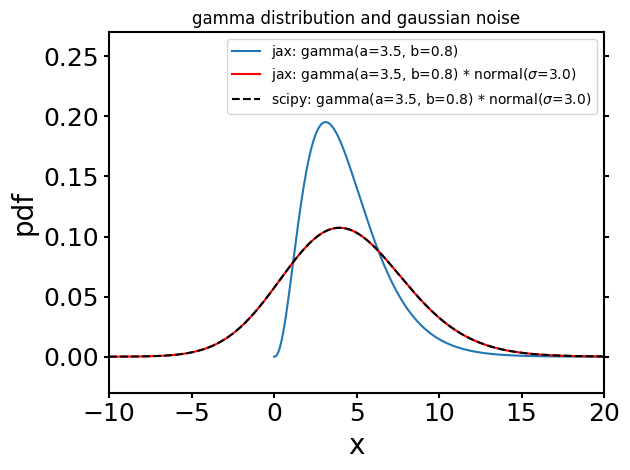

In [80]:
ga = 3.5
gb = 0.8
sigma = 3

xvals = jnp.linspace(-10, 20, 10000)
yvals_n = naive_gamma_jax(xvals, ga, gb)
yvals_c = cgamma_region1_jax_serie(xvals, ga, gb, sigma=sigma)

xvals = np.linspace(-10, 20, 10000)
yvals_csp = cgamma_region1(xvals, ga, gb, sigma=sigma)

fig, ax = plt.subplots()
plt.title("gamma distribution and gaussian noise")

ax.plot(xvals, yvals_n, label=f'jax: gamma(a={ga:.1f}, b={gb:.1f})')
ax.plot(xvals, yvals_c, label=f'jax: gamma(a={ga:.1f}, b={gb:.1f}) * normal($\sigma$={sigma:.1f})', color='red')
ax.plot(xvals, yvals_csp, label=f'scipy: gamma(a={ga:.1f}, b={gb:.1f}) * normal($\sigma$={sigma:.1f})', linestyle='dashed', color='black')

plot_args = {'xlim':[-10, 20],
                 'ylim': [-0.03, 0.27],
                 'xlabel':'x',
                 'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)

plt.tight_layout()
plt.show()